In [1]:
import time
import copy
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from torchdp import PrivacyEngine

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

Warning! Tensorboard library was not found.


In [229]:
class Arguments:
    """Parameters for training"""
    def __init__(self):
        self.epochs = 10
        self.iterations = 1
        self.lr = 0.01
        self.shuffle_dataset = True
        self.batch_size = 8
        self.test_batch_size = 8
        self.log_interval = 10
        self.seed = 1
        self.disable_federated = True
        self.disable_dp = False
        self.alphas=[1.1, 2, 4, 10]
        self.delta = 1.0
        self.workers = 1
        self.disable_verbose_training = True
    

args = Arguments()

torch.manual_seed(args.seed)
kwargs = {}

In [230]:
def load_adult(args):

    data_file = "/home/gwyn/dev/webapp/test/fed-iris/data/adult.data"
    data_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                  'marital-status', 'occupation', 'relationship', 'race', 
                  'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 
                  'native-country', 'income']

    dataframe = pd.read_csv(data_file, names=data_names)
    for i in dataframe.columns:
        dataframe[i].replace(' ?', np.nan, inplace=True)
    dataframe.dropna(inplace=True)
    dataframe.drop(['fnlwgt'], axis=1, inplace=True)

    # This needs to be run multiple times to capture all categorical data, for some reason
    for _ in range(1,5):
        for i in range(dataframe.shape[1]):
            # check if string data, skip if false
            if type(dataframe.iloc[1,i]) == str:
            # list uniques in column
                unique_classes = list(dataframe.iloc[: , i].unique())
            # add binary field for unique with true
                for unique_class in unique_classes:            
                    dataframe[unique_class.replace('-','').strip()] = dataframe.iloc[:,i] == unique_class
                dataframe.drop(axis=1, columns=dataframe.columns[i], inplace=True)

    X = np.array(dataframe.drop('>50K',axis=1).values, dtype='float64')
    y = np.array(dataframe['>50K'].values, dtype='float64')
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, shuffle=args.shuffle_dataset)
    
    return X_train, X_test, y_train, y_test

In [231]:
# separates data and labels and initialises data loaders
def prepare_data(X_train, X_test, y_train, y_test, shuffle_dataset, batch_size, num_workers):

    # Initialise train_loaders list for storing each worker's train_loader
    train_loaders = list()

    # Split training data equally among all workers
    remote_X_train = list()
    remote_X_train.append(np.array_split(X_train, num_workers))

    # Split training labels equally among all workers
    remote_y_train = list()    
    remote_y_train.append(np.array_split(y_train, num_workers))

    # This looks like it's reinitialising these variables as their index 0 values,
    # but it's actually discarding an unwanted outer object layer so that we can directly 
    # reference the data/target lists.
    remote_X_train = remote_X_train[0]
    remote_y_train = remote_y_train[0]

    # Convert training data & labels into torch tensors, then into datasets, then into dataloaders
    for i in range(len(remote_X_train)):
        remote_X_train[i] = torch.tensor(remote_X_train[i]).float()
        remote_y_train[i] = torch.tensor(remote_y_train[i]).float()
        train = TensorDataset(remote_X_train[i], remote_y_train[i])
        train_loaders.append(DataLoader(train, batch_size=batch_size, shuffle=True))

    # Standard test loader setup as we only need one
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    test = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

    return train_loaders, test_loader

In [232]:
# Set up a model, optimiser and renyi privacy engine for each worker (only call if DP is needed)
def prepare_private_training(model, train_loaders, num_workers, batch_size, alphas, lr):
    
    model_pool = list()
    optimizer_pool = list()
    priv_eng_pool = list()

    # We use deepcopy to make wholly independent copies of the shared model
    for _ in range (num_workers):
        model_pool.append(copy.deepcopy(model))

    # We call the SGD constructor each time to ensure model updates are correctly applied
    for model in model_pool:
        opt = optim.SGD(model.parameters(), lr=lr)
        optimizer_pool.append(opt)

    # Attaches privacy engine for each model to each optimiser, effectively replacing
    # gradient calculation functions with similar DP-enabled ones.
    for i in range(len(model_pool)):    
        privacy_engine = PrivacyEngine(
                            model_pool[i],
                            batch_size=batch_size,
                            sample_size=len(train_loaders[i].dataset),
                            alphas=alphas,
                            noise_multiplier = 1.0,
                            max_grad_norm = 1.0)

        privacy_engine.attach(optimizer_pool[i])

    return model_pool, optimizer_pool

In [233]:
# Set up a model and optimiser for each worker (only call if DP is not needed)
def prepare_training(model, train_loaders, num_workers, lr):
    
    model_pool = list()
    optimizer_pool = list()

    # We use deepcopy to make wholly independent copies of the shared model
    for _ in range (num_workers):
        model_pool.append(copy.deepcopy(model))

    # We call the SGD constructor each time to ensure model updates are correctly applied
    for model in model_pool:
        opt = optim.SGD(model.parameters(), lr=lr)
        optimizer_pool.append(opt)

    return model_pool, optimizer_pool

In [234]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(104, 20)
        self.fc2 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
    
    # pass-forward procedure using a relu and a softmax output
    def forward(self, x):
        x = x.view(-1, 104)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [235]:
# Main model training routine
def train(model, optimizer, train_loader, epoch, i, disable_verbose_training, disable_dp, delta):
    model.train()

    # We will store the cross-entropy loss to report it later    
    losses = []

    # Standard pytorch training loop
    for _batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(data)
        #print(pred.view(-1,).data)
        #print(target.view(-1,).data)
        loss = F.binary_cross_entropy(pred.view(-1,), target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if not disable_verbose_training:
        # If DP is enabled, show our data leakage as we go along with loss output
        if not disable_dp:
            epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(delta)
            print(
                    f"Model ID: {i:2d}   "
                    f"Train Epoch: {epoch:2d}   "
                    f"Loss: {np.mean(losses):.6f} "
                    f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
            )
        else:
            # If we are not using DP, just show the loss output 
            print(f"Model ID: {i:2d}   Train Epoch: {epoch:2d}   Loss: {np.mean(losses):.6f}")

In [236]:
# When all workers have trained their local models, bring models together and average them
def aggregate_models(models):

    params = list()
    num_workers = len(models)

    # Deep copying the model parameters directly makes them easier to work with
    for model_id in range(num_workers):
        params.append(list(copy.deepcopy(models[model_id]).parameters()))

        # Remove outer object layer of each parameter list so we can access it directly
        for layer_id in range(len(params[0])):
            params[model_id][layer_id] = params[model_id][layer_id].data

    agg_params = list()

    # Take the mean average of worker parameters at each model layer
    for layer_id in range(len(params[0])):

        agg_layer = params[0][layer_id]

        for worker_id in range(1, num_workers):
            agg_layer = agg_layer + params[worker_id][layer_id]

        agg_layer = agg_layer / num_workers
        agg_params.append(agg_layer)

    # Initialise new shared model to be used, and access parameters directly
    new_model = Net()
    new_params = list(new_model.parameters())

    # Turn off pytorch autograd and overwrite the new model parameters with the averaged params
    with torch.no_grad():
        for layer_index in range(len(new_params)):
            new_params[layer_index].set_(agg_params[layer_index])

    # This will be our new shared model for testing and further training
    return new_model

In [237]:
# Model Test routine
def test(data_loader, model):

    model.eval()
    test_loss = 0

    # Standard pytorch test loop
    for data, target in data_loader:
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability

    # We take the mean of the testing set loss        
    test_loss /= len(data_loader.dataset)

    # We could print the test loss output or just return it.
    # print('Test set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

In [238]:
def select_prepare_training(init_model, train_loaders, args):
    # Case switch based on whether or not we want to use DP (see the Arguments class)
    if not args.disable_dp:
        models,opts = prepare_private_training(init_model, train_loaders, args.workers, args.batch_size, args.alphas, args.lr)
    else:
        models,opts = prepare_training(init_model, train_loaders, args.workers, args.lr)
    
    return models,opts

[False False False ...  True False False]
[False False False ... False False False]
Precision = 0.6874430576434535
Recall = 0.7456570746585334
F1 score = 0.6728768118511583
[[5459  180]
 [1738  164]]
1902
344


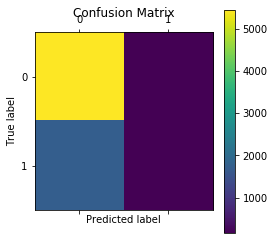

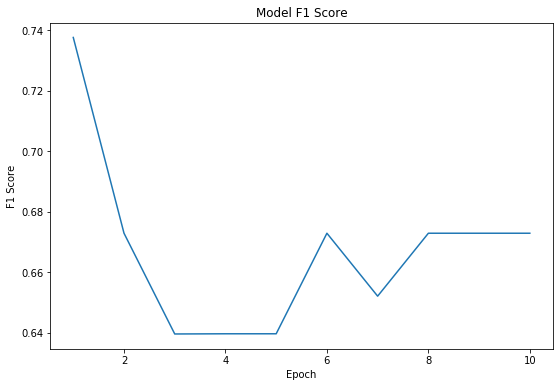

In [239]:
# testing demo function to call all above functions and produce a federated learning model.
init_model = Net()

# Here we're using the Iris dataset - TODO change this for something more challenging
X_train, X_test, y_train, y_test = load_adult(args)

train_loaders, _ = prepare_data(X_train, X_test, y_train, y_test, args.shuffle_dataset, args.batch_size, args.workers)

f1_scores = list()

# Case switch based on whether or not we want to use DP (see the Arguments class)
models,opts = select_prepare_training(init_model, train_loaders, args)

# Train all of our worker models on their local data, then combine and aggregate their models
for epoch in range(1,args.epochs+1):
    for i in range(len(models)):
        train(models[i], opts[i], train_loaders[i], epoch, i, args.disable_verbose_training, args.disable_dp, args.delta)
    new_model = aggregate_models(models)
    models,opts = select_prepare_training(new_model, train_loaders, args)
    
    # Every 5 epochs record the F1 Score of the aggregated model
    if (epoch%1)==0:
        with torch.no_grad():
            pred = np.array(new_model(torch.tensor(X_test).float()))
            y_pred = pred.reshape(-1,)[:] > 0.5
            y_test = y_test.reshape(-1,)[:] > 0.5
            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# Turn off pytorch autograd to run some scikit learn metrics (Precision, Recall, F1 score)
with torch.no_grad():
    pred = np.array(new_model(torch.tensor(X_test).float()))
    y_pred = pred.reshape(-1,)[:] > 0.5
    #y_test = y_test.reshape(-1,)[:] > 0.5
    #print(y_test)
    #print(y_pred)
 
    print(f"Precision = {precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall = {recall_score(y_test, y_pred, average='weighted')}")
    print(f"F1 score = {f1_score(y_test, y_pred, average='weighted')}")

    # Create a confusion matrix to see how well we perform on Iris
    cm = confusion_matrix(y_test, y_pred)
    
    #print(cm)
    
    #print(y_test.sum())
    #print(y_pred.sum())

    # Display confusion matrix
    plt.matshow(cm)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Plot graph of F1 Score history over all epochs
    plt.figure(figsize=(9,6))
    plt.plot(range(1,args.epochs+1),f1_scores)
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')

In [224]:
X_train.shape

(22621, 104)

In [96]:
dataframe.income.value_counts()

 <=50K    22654
 >50K      7508
Name: income, dtype: int64

In [101]:
dataframe.target.sum()/len(dataframe)

0.24892248524633645

In [141]:
dataframe.uniques

AttributeError: 'DataFrame' object has no attribute 'unique'

In [142]:
dataframe.workclass.unique()

0                State-gov
1         Self-emp-not-inc
2                  Private
3                  Private
4                  Private
               ...        
32556              Private
32557              Private
32558              Private
32559              Private
32560         Self-emp-inc
Name: workclass, Length: 30162, dtype: object

In [199]:
dataframe.iloc[[:,1]  == ' Private', 'newclass'] = true

SyntaxError: invalid syntax (<ipython-input-199-670dbe372789>, line 1)

In [182]:
type(dataframe.iloc[1,2]) == str

False

In [153]:
type(dataframe.iloc[1,0])

numpy.int64

In [160]:
unique_classes = list(dataframe.iloc[: , 1].unique())

In [290]:
dataframe.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
target            object
dtype: object

In [ ]:
for i in range(dataframe.shape[1]):
    # check if string data, skip if false
    if dataframe.dtypes[i] == 'O':
    # list uniques in column
        print("\n\n" + dataframe.columns[i] + "\n")
        unique_classes = list(dataframe.iloc[: , i].unique())
    # add binary field for unique with true
        for unique_class in unique_classes: 
            print(unique_class)
            dataframe[unique_class.replace('-','').strip()] = dataframe.iloc[:,i] == unique_class
        dataframe.drop(axis=1, columns=dataframe.columns[i], inplace=True)
    

In [346]:
X = torch.from_numpy(np.array(dataframe.drop('>50K',axis=1).values, dtype='float64'))

In [347]:
X.shape

torch.Size([30162, 104])

In [310]:
y = torch.from_numpy(np.array(dataframe['>50K'].values, dtype='bool'))

In [318]:
y.shape

torch.Size([30162])

In [183]:
for i in range(dataframe.shape[1]):
    print(type(dataframe.iloc[1,i]) == str)

False
True
False
True
False
True
True
True
True
True
False
False
False
True
False


In [168]:
dataframe.shape[1]

15

In [264]:
dataframe.dtypes[3]

dtype('O')

In [266]:
dataframe.dtypes[3] == 'O'

True

In [329]:
dataframe

,age,education-num,capital-gain,capital-loss,hours-per-week,Stategov,Selfempnotinc,Private,Federalgov,Localgov,...,Protectiveserv,ArmedForces,Privhouseserv,<=50K,>50K,White,Black,AsianPacIslander,AmerIndianEskimo,Other
0,39,13,2174,0,40,True,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False
1,50,13,0,0,13,False,True,False,False,False,...,False,False,False,True,False,True,False,False,False,False
2,38,9,0,0,40,False,False,True,False,False,...,False,False,False,True,False,True,False,False,False,False
3,53,7,0,0,40,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,False
4,28,13,0,0,40,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,0,38,False,False,True,False,False,...,False,False,False,True,False,True,False,False,False,False
32557,40,9,0,0,40,False,False,True,False,False,...,False,False,False,False,True,True,False,False,False,False
32558,58,9,0,0,40,False,False,True,False,False,...,False,False,False,True,False,True,False,False,False,False
32559,22,9,0,0,20,False,False,True,False,False,...,False,False,False,True,False,True,False,False,False,False


In [298]:
dataframe.columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'target', 'Stategov', 'Selfempnotinc', 'Private',
       ...
       'Techsupport', 'Craftrepair', 'Protectiveserv', 'ArmedForces',
       'Privhouseserv', 'White', 'Black', 'AsianPacIslander',
       'AmerIndianEskimo', 'Other'],
      dtype='object', length=105)

In [279]:
dataframe.occupation.value_counts()

 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Other-service        3212
 Machine-op-inspct    1966
 Transport-moving     1572
 Handlers-cleaners    1350
 Farming-fishing       989
 Tech-support          912
 Protective-serv       644
 Priv-house-serv       143
 Armed-Forces            9
Name: occupation, dtype: int64

In [281]:
dataframe.Profspecialty.value_counts()

False    26124
True      4038
Name: Profspecialty, dtype: int64

In [214]:
dataframe.iloc[: , 13].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
       ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
       ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
       ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
       ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
       ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
       ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
       ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
       ' Hungary', ' Holand-Netherlands'], dtype=object)

In [215]:
dataframe.iloc[: , 13].value_counts()

 United-States                 27504
 Mexico                          610
 Philippines                     188
 Germany                         128
 Puerto-Rico                     109
 Canada                          107
 El-Salvador                     100
 India                           100
 Cuba                             92
 England                          86
 Jamaica                          80
 South                            71
 China                            68
 Italy                            68
 Dominican-Republic               67
 Vietnam                          64
 Guatemala                        63
 Japan                            59
 Columbia                         56
 Poland                           56
 Taiwan                           42
 Haiti                            42
 Iran                             42
 Portugal                         34
 Nicaragua                        33
 Peru                             30
 Greece                           29
 